# Done using GOOGLE COLAB

Importing the libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os

import cv2
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.densenet import DenseNet121

Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the dataset to local environment

In [ ]:
!apt-get install p7zip-full
!7za x '/content/drive/MyDrive/Datasetzip'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 folder, 1 file, 241675852 bytes (231 MiB)

Extracting archive: /content/drive/MyDrive/Datasetzip/Datastcn.zip
--
Path = /content/drive/MyDrive/Datasetzip/Datastcn.zip
Type = zip
Physical Size = 241675852

  0%      4% 109 - Datastcn/datasetcn/COVID/Covid (1095).png                                                    

Creating a dataframe

In [ ]:
data_train = []
type_of_disease =['COVID', 'non-COVID']
data_directory = '/content/Datastcn/datasetcn'
train_directory = os.path.join(data_directory)

for id, td in enumerate(type_of_disease):
    for file in os.listdir(os.path.join(train_directory, td)):
        data_train.append(['{}/{}'.format(td, file), id, td])
        
train = pd.DataFrame(data_train, columns=['Image', 'Class ID','Type of Disease'])
train.head()

,Image,Class ID,Type of Disease
0,COVID/Covid (181).png,0,COVID
1,COVID/Covid (923).png,0,COVID
2,COVID/Covid (228).png,0,COVID
3,COVID/Covid (476).png,0,COVID
4,COVID/Covid (1228).png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))
train.head() 

,Image,Class ID,Type of Disease
0,COVID/Covid (1168).png,0,COVID
1,COVID/Covid (1175).png,0,COVID
2,non-COVID/Non-Covid (133).png,1,non-COVID
3,non-COVID/Non-Covid (606).png,1,non-COVID
4,COVID/Covid (569).png,0,COVID


Checking the no. of images in each class 

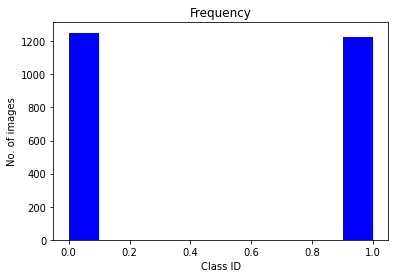

In [ ]:
plt.hist(train['Class ID'],color = "blue")
plt.xlabel('Class ID')
plt.ylabel('No. of images')
plt.title('Frequency')
plt.show()

Resizing the input image according to the input shape

In [ ]:
def show_images(disease_type, r, c):
    fig,ax = plt.subplots(r,c, figsize=(10,10))
    disease_image = train['Image'][train['Type of Disease'] == disease_type].values
    n = 0
    print(disease_type+' images')
    for i in range(r):
        for j in range(c):
            image = os.path.join(data_directory, disease_image[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image))
            n += 1


Plotting the covid images

COVID images


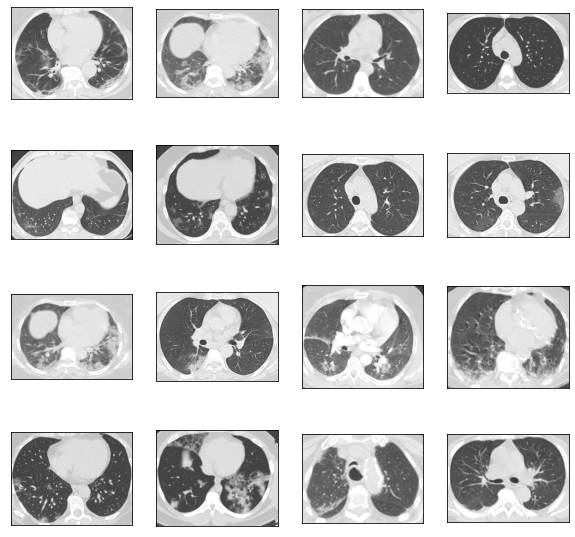

In [ ]:
show_images('COVID',4,4) 

Plotting the non-covid images

non-COVID images


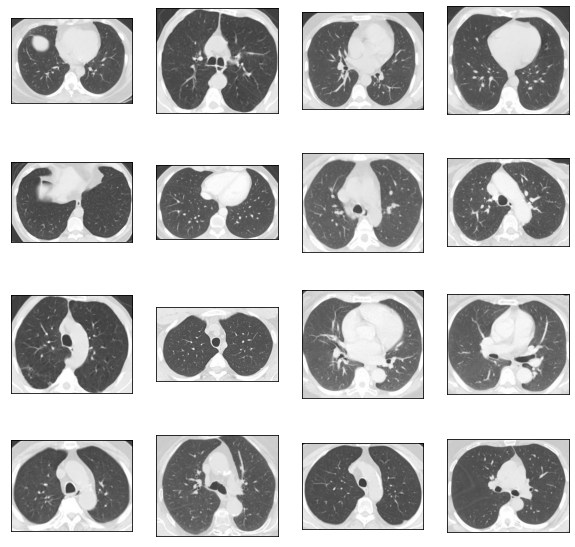

In [ ]:
show_images('non-COVID',4,4)

In [ ]:
SIZE_OF_IMAGE = 64
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)

Reshaping all the images to 64 * 64 * 3

In [ ]:
x_train = np.zeros((train.shape[0], SIZE_OF_IMAGE, SIZE_OF_IMAGE, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train[i] = resize_image(image,(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
        
X_Train = x_train / 255

print('Train shape: {}'.format(X_Train.shape))

2481it [00:07, 328.49it/s]


Train shape: (2481, 64, 64, 3)


In [ ]:
y_train = train['Class ID'].values
y_train = to_categorical(y_train, num_classes=2)

Train test split(0.8,0.2)

In [ ]:
BATCH_SIZE = 64

X_train, X_test, Y_train, Y_test = train_test_split(X_Train,y_train, test_size=0.2, random_state=SEED)

Plotting the reshaped images

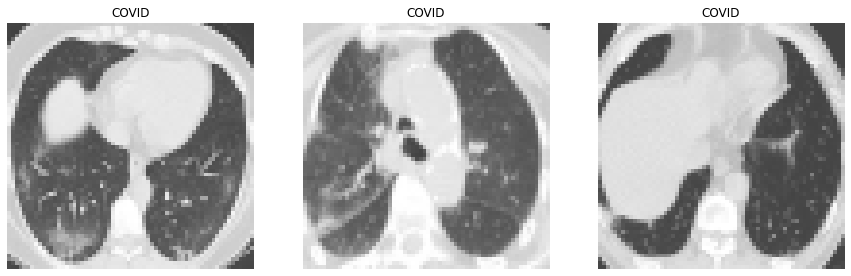

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(type_of_disease[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 100
SIZE=64
N_ch=3

Creating the densenet121 model with imagenet weights initially and trained the model

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(2,activation = 'softmax', name='root')(x)
 
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/densenet2105.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, Y_test))

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
31/31 - 51s - loss: 1.1538 - accuracy: 0.5600 - val_loss: 0.6791 - val_accuracy: 0.6278

Epoch 00001: val_loss improved from inf to 0.67910, saving model to /content/drive/MyDrive/Colab Notebooks/densenet2105.h5
Epoch 2/100
31/31 - 4s - loss: 0.9601 - accuracy: 0.6331 - val_loss: 0.7429 - val_accuracy: 0.6036

Epoch 00002: val_loss did not improve from 0.67910
Epoch 3/100
31/31 - 3s - loss: 0.8471 - accuracy: 0.6714 - val_loss: 0.8868 - val_accuracy: 0.5755

Epoch 00003: val_loss did not improve from 0.67910
Epoch 4/100
31/31 - 4s - loss: 0.7486 - accuracy: 0.6981 - val_loss: 0.9745 - val_accuracy: 0.5694

Epoch 00004: val_loss did not improve from 0.67910
Epoch 5/100
31/31 - 3s - loss: 0.6945 - accuracy: 0.7172 - val_loss: 0.8842 - val_accuracy: 0.6036

Epoch 00005: val_loss did not improve from 0.67910
Epoch 6/100
31/31 - 3s - loss: 0.6129 - accuracy: 0.7445 - val_loss: 0.8977 - val_accuracy: 0.6318

Epoch 00006: val_loss did not improve from 0.67910
Epoch 7/100
31/31 - 3

Saving the model

In [ ]:
final_loss, final_acc = model.evaluate(X_test, Y_test)
print("*************************")
print('Loss: {}, Accuracy:{}'.format(final_loss, final_acc))

16/16 [==============================] - 0s 21ms/step - loss: 0.1493 - accuracy: 0.9416
*************************
Loss: 0.14933447539806366, Accuracy:0.9416499137878418


Predicting the test images

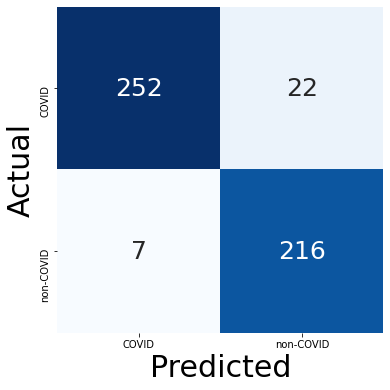

In [ ]:
Y_predict = model.predict(X_test)
Y_predict = np.argmax(Y_predict, axis= 1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_predict)
plt.figure(figsize=(6,6))

ax= sns.heatmap(cm, cmap=plt.cm.Blues, annot=True,fmt='d',annot_kws={"size": 25},cbar=False, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.savefig('Confusion matrix_densenet.svg', format='svg', dpi=1200)

Accuracy and Loss plot

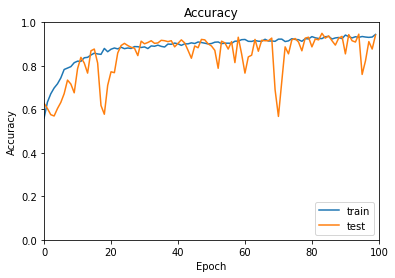

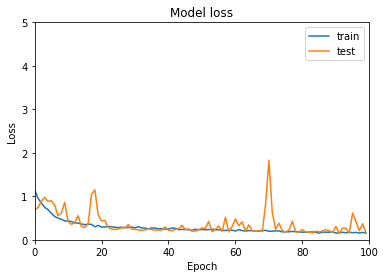

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlim(0,100)
plt.ylim(0,1)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='lower right')
plt.savefig('Accuracy plot_densenet.svg', format='svg', dpi=1200)
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlim(0,100)
plt.ylim(0,5)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper right')
plt.savefig('Model loss plot_densenet.svg', format='svg', dpi=1200)
plt.show()

In [ ]:
def confusion_metrics (conf_matrix):

    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    #accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    #mis-classification
    conf_misclassification = 1- conf_accuracy
    
    #sensitivity
    conf_sensitivity = (TP / float(TP + FN))

    #specificity
    conf_specificity = (TN / float(TN + FP))
    
    #precision
    conf_precision = (TN / float(TN + FP))

    # f1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)

    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f1 Score: {round(conf_f1,2)}')

In [ ]:
metrics = confusion_metrics(cm)
print(metrics)

True Positives: 216
True Negatives: 252
False Positives: 22
False Negatives: 7
--------------------------------------------------
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.97
Specificity: 0.92
Precision: 0.92
f1 Score: 0.94
None
